## General Case (Empirical)

$$
LVR =  \sum_{i=1}^{n} a_i \cdot (p_i - q_i)
$$

$a_i$ : Amount of Token Sold

$p_i$ : Market Price

$q_i$ : AMM Price

## Getting Swap Data for the Pool

In [245]:
# load swap data from csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('USDCETH_swap.csv', index_col=0)


In [301]:
from web3 import Web3

web3 = Web3(Web3.HTTPProvider("https://eth.llamarpc.com"))

def get_block_timestamp(block_number):
    block = web3.eth.get_block(block_number)
    
    if block:
        timestamp = block['timestamp']
        return timestamp
    else:
        return None

# Example usage
block_number = 17619769
timestamp = get_block_timestamp(block_number)
datetime = pd.to_datetime(timestamp, unit='s')

if timestamp:
    print("Timestamp for block", block_number, ":", timestamp, "(", datetime, ")")
else:
    print("Failed to retrieve timestamp for block", block_number)


Timestamp for block 17619769 : 1688464115 ( 2023-07-04 09:48:35 )


In [500]:
swaps = df[-2500:]
swaps

,block_number,amount0,amount1,liquidity,tick,transaction_index,log_index,amount_token0,amount_token1,Price
chain,,,,,,,,,,
ethereum,17619769,-1.077014e+10,5.518087e+18,4.574664e+19,200550,7,37,-10770.143513,5.518087,1952.808358
ethereum,17619769,1.085832e+10,-5.557701e+18,4.574664e+19,200550,10,62,10858.316787,-5.557701,1952.808358
ethereum,17619779,-1.513387e+09,7.753807e+17,4.574664e+19,200550,63,84,-1513.386854,0.775381,1952.808358
ethereum,17619782,1.016229e+11,-5.201192e+19,5.385767e+19,200549,0,2,101622.882399,-52.011919,1953.003639
ethereum,17619784,1.144758e+11,-5.858487e+19,5.385767e+19,200548,0,2,114475.773229,-58.584865,1953.198939
...,...,...,...,...,...,...,...,...,...,...
ethereum,17626307,-3.997398e+09,2.064475e+18,4.804907e+19,200630,57,145,-3997.398083,2.064475,1937.248990
ethereum,17626308,1.457979e+09,-7.522283e+17,4.804907e+19,200630,76,119,1457.979055,-0.752228,1937.248990
ethereum,17626312,-2.601650e+10,1.343652e+19,4.804907e+19,200630,1,19,-26016.496670,13.436515,1937.248990


In [501]:
# insert timestamp column
swaps['timestamp'] = swaps['block_number'].apply(get_block_timestamp)

# save to csv
swaps.to_csv('USDCETH_swap_timestamp.csv')

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_38979/4243738665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps['timestamp'] = swaps['block_number'].apply(get_block_timestamp)


In [736]:
# load swaps csv
swaps = pd.read_csv('USDCETH_swap_timestamp.csv', index_col=0)

In [737]:
swaps = swaps[:2300]

In [738]:
# find the number of items with the same block number, divide 12 by this number, and store it in a new column called count
swaps['count'] = swaps.groupby('block_number')['block_number'].transform('count')
swaps['delay'] = 12 / swaps['count']
# for every item with the same block number, create a column keepig a cum sum of delay
swaps['cum_count'] = swaps.groupby('block_number')['delay'].cumsum()

# for every item with the same block number, take the values from cum sum, scramble their order, and add them to a new column called cum count randomised
swaps['cum_count_randomised'] = swaps.groupby('block_number')['cum_count'].transform(np.random.permutation)

# subtract cum count from timestamp
swaps['timestamp'] = swaps['timestamp'] - swaps['cum_count']
swaps['timestamp'] = swaps['timestamp'].astype(int)
swaps

,block_number,amount0,amount1,liquidity,tick,transaction_index,log_index,amount_token0,amount_token1,Price,timestamp,count,delay,cum_count,cum_count_randomised
chain,,,,,,,,,,,,,,,
ethereum,17619769,-1.077014e+10,5.518087e+18,4.574664e+19,200550,7,37,-10770.143513,5.518087,1952.808358,1688464109,2,6.0,6.0,6.0
ethereum,17619769,1.085832e+10,-5.557701e+18,4.574664e+19,200550,10,62,10858.316787,-5.557701,1952.808358,1688464103,2,6.0,12.0,12.0
ethereum,17619779,-1.513387e+09,7.753807e+17,4.574664e+19,200550,63,84,-1513.386854,0.775381,1952.808358,1688464235,1,12.0,12.0,12.0
ethereum,17619782,1.016229e+11,-5.201192e+19,5.385767e+19,200549,0,2,101622.882399,-52.011919,1953.003639,1688464271,1,12.0,12.0,12.0
ethereum,17619784,1.144758e+11,-5.858487e+19,5.385767e+19,200548,0,2,114475.773229,-58.584865,1953.198939,1688464295,1,12.0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethereum,17625521,-1.572259e+07,8.117950e+15,4.810845e+19,200627,28,54,-15.722592,0.008118,1937.830222,1688533895,1,12.0,12.0,12.0
ethereum,17625526,6.000000e+07,-3.094846e+16,4.810845e+19,200627,67,181,60.000000,-0.030948,1937.830222,1688533955,1,12.0,12.0,12.0
ethereum,17625527,3.713780e+09,-1.915593e+18,4.810845e+19,200627,9,29,3713.779571,-1.915593,1937.830222,1688533973,2,6.0,6.0,6.0


In [713]:
# get start and end timestamps in swaps

start_timestamp = swaps['timestamp'].min() * 1000
end_timestamp = swaps['timestamp'].max() * 1000
print(start_timestamp, end_timestamp)

# convert the timestamps into datetime, singapore time
start_datetime = pd.to_datetime(start_timestamp, unit='ms') + pd.Timedelta(hours=8)
end_datetime = pd.to_datetime(end_timestamp, unit='ms') + pd.Timedelta(hours=8)


print(start_datetime, end_datetime)

1688464103000 1688533991000
2023-07-04 17:48:23 2023-07-05 13:13:11


In [714]:
# get the difference between the two timestamps in hours
diff = (end_timestamp - start_timestamp) / 1000 / 60 / 60
print(diff)

19.413333333333334


In [597]:
import requests

# Helper function to get binance klines over a period longer than 1000 seconds

def get_binance_klines(symbol, startTime, endTime):
    url = "https://api.binance.com/api/v3/uiKlines"
    params = {
        "symbol": symbol,
        "interval": "1s",
        "startTime": startTime,
        "endTime": 1688535695000,
        "limit": "1000"
    }

    data = []

    while True:
        response = requests.get(url, params=params)

        if response.status_code == 200:
            batch_data = response.json()
            data.extend(batch_data)

            if len(batch_data) < 1000:
                break

            # Update the startTime parameter for the next batch
            params["startTime"] = str(int(batch_data[-1][0]) + 1)
        else:
            print("Request failed with status code:", response.status_code)
            break

    return data

# klines_data = get_binance_klines()
# print("Total data points:", len(klines_data))


In [715]:
response = get_binance_klines("ETHUSDC", start_timestamp, end_timestamp)
klines_data = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

In [514]:
url = "https://api.binance.com/api/v3/uiKlines"
params = {
    "symbol": "ETHUSDC",
    "interval": "1s",
}
response = requests.get(url, params=params)
# convert to pd dataframe

test = pd.DataFrame(response.json(), columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create a column to store date time in singapore timezone using the open_time column
test['datetime'] = pd.to_datetime(test['open_time'], unit='ms') + pd.Timedelta(hours=8)

# move the datetime column to the front
test = test[['datetime', 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']]

# save to csv
test.to_csv('ETHUSDC_1s.csv')

test

,datetime,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2023-07-05 22:27:27,1688567247000,1906.85000000,1906.85000000,1906.85000000,1906.85000000,0.00000000,1688567247999,0.00000000,0,0.00000000,0.00000000,0
1,2023-07-05 22:27:28,1688567248000,1906.85000000,1906.85000000,1906.85000000,1906.85000000,0.00000000,1688567248999,0.00000000,0,0.00000000,0.00000000,0
2,2023-07-05 22:27:29,1688567249000,1906.85000000,1906.85000000,1906.85000000,1906.85000000,0.00000000,1688567249999,0.00000000,0,0.00000000,0.00000000,0
3,2023-07-05 22:27:30,1688567250000,1906.85000000,1906.85000000,1906.85000000,1906.85000000,0.00000000,1688567250999,0.00000000,0,0.00000000,0.00000000,0
4,2023-07-05 22:27:31,1688567251000,1906.85000000,1906.85000000,1906.85000000,1906.85000000,0.00000000,1688567251999,0.00000000,0,0.00000000,0.00000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-07-05 22:35:42,1688567742000,1908.11000000,1908.11000000,1908.11000000,1908.11000000,0.00000000,1688567742999,0.00000000,0,0.00000000,0.00000000,0
496,2023-07-05 22:35:43,1688567743000,1908.11000000,1908.11000000,1908.11000000,1908.11000000,0.00000000,1688567743999,0.00000000,0,0.00000000,0.00000000,0
497,2023-07-05 22:35:44,1688567744000,1908.11000000,1908.11000000,1908.11000000,1908.11000000,0.00000000,1688567744999,0.00000000,0,0.00000000,0.00000000,0
498,2023-07-05 22:35:45,1688567745000,1908.11000000,1908.11000000,1908.11000000,1908.11000000,0.00000000,1688567745999,0.00000000,0,0.00000000,0.00000000,0


In [716]:
# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000

klines_data = klines_data[['open_time', 'close_time', 'close']]
klines_data['open_time'] = klines_data['open_time'] / 1000
klines_data['close_time'] = klines_data['close_time'] / 1000

# convert open_time and close_time to int
klines_data['open_time'] = klines_data['open_time'].astype(int)
klines_data['close_time'] = klines_data['close_time'].astype(int)

klines_data

,open_time,close_time,close
0,1688464103,1688464103,1952.40000000
1,1688464104,1688464104,1952.83000000
2,1688464105,1688464105,1952.83000000
3,1688464106,1688464106,1952.83000000
4,1688464107,1688464107,1952.83000000
...,...,...,...
71588,1688535691,1688535691,1935.43000000
71589,1688535692,1688535692,1935.43000000
71590,1688535693,1688535693,1935.43000000
71591,1688535694,1688535694,1935.43000000


In [717]:
# merge swaps and klines_data on timestamp and close_time
merged = pd.merge(swaps, klines_data, left_on='timestamp', right_on='close_time')

# drop open_time and close_time and liquidity and tick and transaction_index and log_index
merged = merged.drop(columns=['open_time', 'close_time', 'liquidity', 'tick',  'log_index'])

# calculate AMM price from amount_token0 divided by amount_token1
merged['AMM_price'] = merged['amount_token0'] / merged['amount_token1'] * -1

merged['close'] = merged['close'].astype(float)

# calculate LVR amount_token1*-1 * (close - AMM_price)
merged['LVR'] = merged['amount_token1'] * -1 * (merged['close'] - merged['Price'])

# create a column for cumulative LVR sum
merged['cum_LVR'] = merged['LVR'].cumsum()

In [638]:
# Get outliers
outliers = merged[merged['LVR'] < -15000]
outliers

,block_number,amount0,amount1,transaction_index,amount_token0,amount_token1,Price,timestamp,close,AMM_price,LVR,cum_LVR


In [639]:
# get items with block_number = 17625659
merged[merged['block_number'] == 17625659]

# -2597740 USDC swapped for 1346 ETH

,block_number,amount0,amount1,transaction_index,amount_token0,amount_token1,Price,timestamp,close,AMM_price,LVR,cum_LVR


The premise of LVR is that if someone were to execute the exact same trades on a CEX, they would be better off. We compare this by looking at timestampped prices in the AMM and CEX. However, if there are many trades within a block (worse if there are sandwich attacks by MEV bots), this comparison cannot be made. Technically the trades are all happening at the 'same' time within the block. 

### Optimisation 1 [Done]

We can try to introduce some artificial delay to transactions happening in the block, by using their order, and distributing the 12s block time.

### Optimisation 2 [Not Done]

Identify and Aggregate MEV Transactions. So get the net movement of ETH for the whole Sandwich trade, and calculate LVR for that instead. 

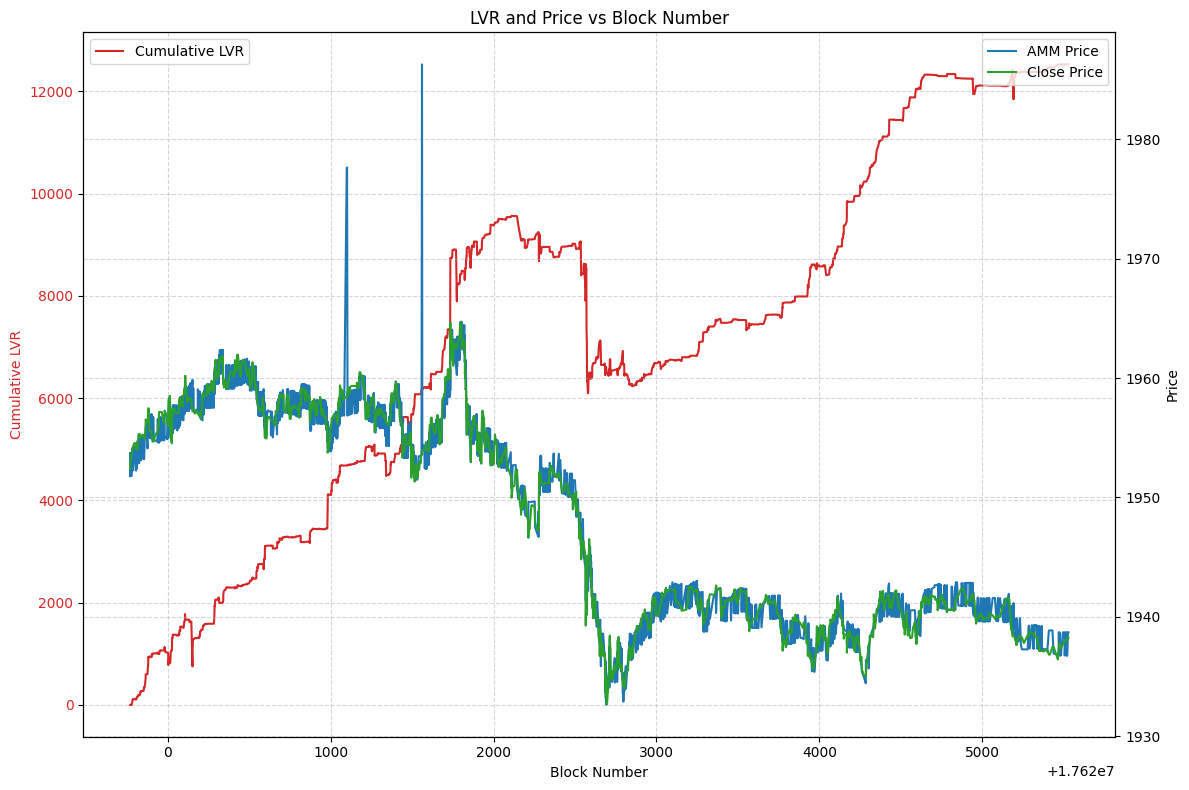

In [718]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR'], color=color1, label='Cumulative LVR')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['AMM_price'], color=color2, label='AMM Price')
ax2.plot(merged['block_number'], merged['close'], color=color3, label='Close Price')
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set title
plt.title('LVR and Price vs Block Number')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [719]:
# sum of LVR
merged['LVR'].sum()

12530.001360654262

In [135]:
import requests

# Define the subgraph endpoint URL
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

# Define the query
query = '''
query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
  pool(id: $poolId) {
    swaps(first:1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
      id
      timestamp
      amount0
      amount1
      sender
      tick
      token0 {
        symbol
        id
        decimals
      }
      token1 {
        symbol
        id
        decimals
      }
      sqrtPriceX96
      transaction {
      id
      blockNumber
      }
    }
  }
}
'''

# Define the request payload
payload = {
    'query': query,
    'variables': {
        'poolId': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
        'startTime': 1685562594,
        'endTime': 1688154594    
    }
}

# Send the POST request to the subgraph endpoint
response = requests.post(subgraph_url, json=payload)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    swaps = data['data']['pool']['swaps']
    
    # Process the retrieved swaps
    for swap in swaps[:10]:
        swap_id = swap['id']
        timestamp = swap['timestamp']
        amount0 = swap['amount0']
        amount1 = swap['amount1']
        sender = swap['sender']
        tick = swap['tick']
        token0_symbol = swap['token0']['symbol']
        token0_id = swap['token0']['id']
        token0_decimals = swap['token0']['decimals']
        token1_symbol = swap['token1']['symbol']
        token1_id = swap['token1']['id']
        token1_decimals = swap['token1']['decimals']
        sqrtPriceX96 = swap['sqrtPriceX96']
        transactin_id = swap['transaction']['id']
        blockNumber = swap['transaction']['blockNumber']

        # Calculate the prices
        price0 = float(amount1) / float(amount0) *-1
        price1 = float(amount0) / float(amount1) *-1
        price0_sqrt = ((float(sqrtPriceX96)/2**96)**2) / (10**float(token1_decimals) / 10**float(token0_decimals))
        price1_sqrt = 1 / price0_sqrt
        
        # Do something with the swap and price data
        print('Transaction ID:', transactin_id)
        print('Block Number:', blockNumber)
        print('Swap ID:', swap_id)
        print('Timestamp:', timestamp)
        print('Amount 0:', amount0)
        print('Amount 1:', amount1)
        print('Sender:', sender)
        print('Tick:', tick)
        print('Token 0 Symbol:', token0_symbol)
        print('Token 0 ID:', token0_id)
        print('Token 0 Decimals:', token0_decimals)
        print('Token 1 Symbol:', token1_symbol)
        print('Token 1 ID:', token1_id)
        print('Token 1 Decimals:', token1_decimals)
        print('Price 0:', price0)
        print('Price 1:', price1)
        print('Price 0 (sqrt):', price0_sqrt)
        print('Price 1 (sqrt):', price1_sqrt)
        print('---')
else:
    print('Error occurred while making the request. Status Code:', response.status_code)


Transaction ID: 0x000237dceda5381904ed2354dd9dcbaea725abbddf795286c8032ae0e94f41df
Block Number: 17507258
Swap ID: 0x000237dceda5381904ed2354dd9dcbaea725abbddf795286c8032ae0e94f41df#5097586
Timestamp: 1687098491
Amount 0: 35
Amount 1: -0.020161266214804987
Sender: 0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
Tick: 201731
Token 0 Symbol: USDC
Token 0 ID: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Token 0 Decimals: 6
Token 1 Symbol: WETH
Token 1 ID: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
Token 1 Decimals: 18
Price 0: 0.0005760361775658568
Price 1: 1736.0020758169699
Price 0 (sqrt): 0.0005763243154409208
Price 1 (sqrt): 1735.1341479231937
---
Transaction ID: 0x0002a4072a44bf8e13f9283a3df3b449017aedb275dddb728ead57496b36e700
Block Number: 17517034
Swap ID: 0x0002a4072a44bf8e13f9283a3df3b449017aedb275dddb728ead57496b36e700#5102435
Timestamp: 1687217099
Amount 0: -56.035514
Amount 1: 0.032322175171173751
Sender: 0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
Tick: 201735
Token 0 Symbol: USDC
T

# Compare AMM Price to Binance Historical Klines (Closing Price every Minute)

In [197]:
import requests
import datetime
from binance.client import Client

def calculate_lvr_sum(pool_id, binance_symbol, subgraph_url):
    # # Create a Binance client
    # binance_client = Client()

    # # Get the historical klines from Binance
    # binance_klines = binance_client.get_historical_klines(binance_symbol, Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

    # # Extract the timestamps and prices from Binance klines
    klines_data = get_binance_klines(binance_symbol, 1688458860000, 1688545200000)

    binance_data = []

    for kline in klines_data:
        timestamp = int(kline[0]) // 1000  # Convert milliseconds to seconds
        price = float(kline[4])

        binance_data.append({
            'Timestamp_binance': timestamp,
            'Binance Price': price
        })

    # Get the start and end timestamps from Binance klines
    start_timestamp_binance = binance_data[0]['Timestamp_binance']
    end_timestamp_binance = binance_data[-1]['Timestamp_binance']

    # Convert timestamps to datetime objects
    start_datetime_binance = datetime.datetime.fromtimestamp(start_timestamp_binance)
    end_datetime_binance = datetime.datetime.fromtimestamp(end_timestamp_binance)

    print("Start Timestamp (Binance):", start_timestamp_binance)
    print("End Timestamp (Binance):", end_timestamp_binance)
    print("Start Datetime (Binance):", start_datetime_binance)
    print("End Datetime (Binance):", end_datetime_binance)

    # Define the subgraph query
    query = '''
    query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
      pool(id: $poolId) {
        swaps(first: 1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
          id
          timestamp
          amount0
          amount1
          sqrtPriceX96
          sender
          tick
        token0 {
            symbol
            id
            decimals
        }
        token1 {
            symbol
            id
            decimals
        }
        }
      }
    }
    '''

    # Define the request payload for the subgraph
    subgraph_payload = {
        'query': query,
        'variables': {
            'poolId': pool_id,
            'startTime': start_timestamp_binance,
            'endTime': end_timestamp_binance,
        }
    }

    # Send the POST request to the subgraph endpoint
    subgraph_response = requests.post(subgraph_url, json=subgraph_payload)

    # Check if the subgraph request was successful
    if subgraph_response.status_code == 200:
        subgraph_data = subgraph_response.json()
        swaps = subgraph_data['data']['pool']['swaps']

        # Extract timestamps, prices, and amount0 from subgraph data
        subgraph_data = []
        for swap in swaps:
            timestamp = swap['timestamp']

            amount1 = float(swap['amount1'])
            amount0 = float(swap['amount0'])
            token0_symbol = swap['token0']['symbol']
            token0_id = swap['token0']['id']
            token0_decimals = swap['token0']['decimals']
            token1_symbol = swap['token1']['symbol']
            token1_id = swap['token1']['id']
            token1_decimals = swap['token1']['decimals']
            sqrtPriceX96 = swap['sqrtPriceX96'] # This is the price after the swap
            price = float(swap['amount0']) / float(swap['amount1']) * -1
            swap_id = swap['id']
            price0_sqrt = ((float(sqrtPriceX96)/2**96)**2) / (10**float(token1_decimals) / 10**float(token0_decimals))
            price1_sqrt = 1 / price0_sqrt

            subgraph_data.append({
                'Timestamp_subgraph': timestamp,
                'Swap Price': price,
                'After Swap Price': price1_sqrt,
                'Amount1': amount1,
                'Amount0': amount0,
                'Swap ID': swap_id
            })
    else:
        print('Error occurred while making the subgraph request. Status Code:', subgraph_response.status_code)
        subgraph_data = []

    # Compare the subgraph and Binance data
    output = []
    timestamps_seen = set()
    binance_timestamps_seen = set()

    for subgraph_item in subgraph_data:
        subgraph_timestamp = subgraph_item['Timestamp_subgraph']
        swap_price = subgraph_item['Swap Price']
        after_swap_price = subgraph_item['After Swap Price']
        subgraph_amount1 = subgraph_item['Amount1']
        subgraph_amount0 = subgraph_item['Amount0']
        subgraph_id = subgraph_item['Swap ID']

        for binance_item in binance_data:
            binance_timestamp = binance_item['Timestamp_binance']
            binance_price = binance_item['Binance Price']

            if abs(int(subgraph_timestamp) - int(binance_timestamp)) <= 30 and subgraph_timestamp not in timestamps_seen:
                LVR = -subgraph_amount1 * (binance_price - swap_price) 

                output.append({
                    'Swap ID': subgraph_id,
                    'Timestamp_subgraph': subgraph_timestamp,
                    'Timestamp_binance': binance_timestamp,
                    'Swap Price': swap_price,
                    'After Swap Price': after_swap_price,
                    'Binance Price': binance_price,
                    'Amount0': subgraph_amount0,
                    'Amount1': subgraph_amount1,
                    'LVR': LVR
                    # amount1 => if negative => token is leaving the pool or SELLING
                    # if positive, token is entering the pool or BUYING
                })
                timestamps_seen.add(subgraph_timestamp)
                binance_timestamps_seen.add(binance_timestamp)

    lvr_sum = 0

    for item in output:
        # print(item)

        lvr_sum += item['LVR']
    return lvr_sum, output

## USDC/ETH Pool 0.05% 

In [198]:
# Example usage
pool_id = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
binance_symbol = 'ETHUSDC'
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

lvr_sum,data = calculate_lvr_sum(pool_id, binance_symbol, subgraph_url)
print("LVR Sum:", lvr_sum)

Start Timestamp (Binance): 1688458860
End Timestamp (Binance): 1688545200
Start Datetime (Binance): 2023-07-04 16:21:00
End Datetime (Binance): 2023-07-05 16:20:00
LVR Sum: -37969.817497332726


In [167]:
lvr_values = []
for item in data:
    if item['LVR'] > -10000:
        lvr_values.append(item['LVR'])

print(sum(lvr_values))

-15262.078405487477


In [152]:
# find this swap id in data
id = "0x144ff66f5fbabda6f05f2d138f90447c520c5280f1dd765a80c7e3d011842628"
for item in data:
    if item['Swap ID'].split('#')[0] == id:
        print(item)

## Visualising LVR Calculations to find outliers

Index: 845
Index - 1: {'Swap ID': '0x55497563dddad9efbe117e87bc8d88aaca8837e0c04fa11e0acc917fe2c70d04#5173487', 'Timestamp_subgraph': '1688535191', 'Timestamp_binance': 1688535161, 'Swap Price': 1938.8699759582344, 'After Swap Price': 1937.900770331068, 'Binance Price': 1938.11, 'Amount0': 250.0, 'Amount1': -0.12894108583864383, 'LVR': -0.09799212526601551} 2023-07-05 13:33:11 2023-07-05 13:32:41
{'Swap ID': '0x0c17b57c8f46918c1fc93d05c823fe659b5fc3dee664b08d8de91881991e336e#5173494', 'Timestamp_subgraph': '1688535563', 'Timestamp_binance': 1688535533, 'Swap Price': 1931.4577551578398, 'After Swap Price': 1927.6541285387946, 'Binance Price': 1935.52, 'Amount0': -5246425.100143, 'Amount1': 2716.3033134598686, 'LVR': -11034.289124845081} 2023-07-05 13:39:23 2023-07-05 13:38:53
Index + 1: {'Swap ID': '0x1a868296291fdda87affa3dd671399e81608f8764913e51644bbe2e36c396760#5173499', 'Timestamp_subgraph': '1688535575', 'Timestamp_binance': 1688535545, 'Swap Price': 1935.7886360110554, 'After Swa

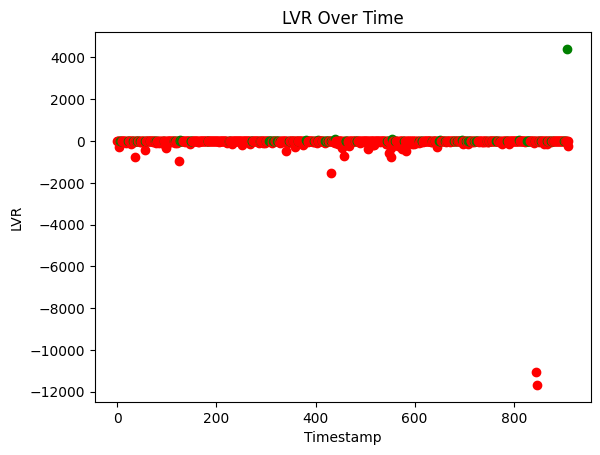

In [168]:
import matplotlib.pyplot as plt

lvr_values = []

#sort data by timestamp
data.sort(key=lambda x: x['Timestamp_subgraph'])

for item in data:
    # if item['LVR'] > -10000:
    #     lvr_values.append(item['LVR'])
    lvr_values.append(item['LVR'])
    if item['LVR'] < -10000:
        # print the items before and after this given item
        index = data.index(item)
        print("Index:", index)
        
        print("Index - 1:", data[index-1], datetime.datetime.fromtimestamp(int(data[index-1]['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(data[index-1]['Timestamp_binance'])))
        print(item, datetime.datetime.fromtimestamp(int(item['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(item['Timestamp_binance'])))
        print("Index + 1:", data[index+1], datetime.datetime.fromtimestamp(int(data[index+1]['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(data[index+1]['Timestamp_binance'])))
        

# Create x-axis values (e.g., timestamps or indices)
x_values = range(len(lvr_values))

# Plot the LVR values
for i in range(len(lvr_values)):
    if lvr_values[i] >= 0:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='green')
    else:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='red')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('LVR')
plt.title('LVR Over Time')

# Show the plot
plt.show()


Outliers on this chart less than -10000 are both MEV Transactions. We must account for these transactions. 

## ETH/GRT Pool 0.3%

In [125]:
lvr_sum,data = calculate_lvr_sum("0x0e2c4be9f3408e5b1ff631576d946eb8c224b5ed", "GRTETH", subgraph_url)
print("LVR Sum:", lvr_sum)

Start Timestamp (Binance): 1688449680
End Timestamp (Binance): 1688536020
Start Datetime (Binance): 2023-07-04 13:48:00
End Datetime (Binance): 2023-07-05 13:47:00
LVR Sum: -0.12747396289966512


In [98]:
import ccxt
from pprint import pprint

print('CCXT Version:', ccxt.__version__)

exchange = ccxt.binance()
timestamp = 1688484515000
response = exchange.fetch_ohlcv('ETH/USDC', '1m', timestamp, 1)
pprint(response)

CCXT Version: 4.0.5
[[1688484540000, 1952.74, 1953.4, 1952.24, 1953.4, 1.8629]]


In [209]:
import requests
import datetime
import ccxt
from pprint import pprint

def calculate_lvr_sum(pool_id, ccxt_symbol, subgraph_url):
    # Create a CCXT exchange instance
    exchange = ccxt.binance()

    # Get the start and end timestamps for the past 24 hours
    end_timestamp_ccxt = int(datetime.datetime.now().timestamp()) * 1000  # Current timestamp in milliseconds
    # start_timestamp_ccxt = end_timestamp_ccxt - 24 * 60 * 60 * 1000  # Subtract 24 hours in milliseconds
    start_timestamp_ccxt = end_timestamp_ccxt - 24 * 60 * 60 * 1000  # Subtract 24 hours in milliseconds

    # Convert timestamps to datetime objects
    start_datetime_ccxt = datetime.datetime.fromtimestamp(start_timestamp_ccxt // 1000)
    end_datetime_ccxt = datetime.datetime.fromtimestamp(end_timestamp_ccxt // 1000)

    print("Start Timestamp (CCXT):", start_timestamp_ccxt)
    print("End Timestamp (CCXT):", end_timestamp_ccxt)
    print("Start Datetime (CCXT):", start_datetime_ccxt)
    print("End Datetime (CCXT):", end_datetime_ccxt)

    # Define the subgraph query and request payload
    query = '''
    query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
      pool(id: $poolId) {
        swaps(first: 1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
          id
          timestamp
          amount0
          amount1
          sqrtPriceX96
          sender
          tick
        }
      }
    }
    '''

    subgraph_payload = {
        'query': query,
        'variables': {
            'poolId': pool_id,
            'startTime': start_timestamp_ccxt // 1000,
            'endTime': end_timestamp_ccxt // 1000,
        }
    }

    # Send the POST request to the subgraph endpoint
    subgraph_response = requests.post(subgraph_url, json=subgraph_payload)

    # Check if the subgraph request was successful
    if subgraph_response.status_code == 200:
        subgraph_data = subgraph_response.json()
        swaps = subgraph_data['data']['pool']['swaps']
        # Extract timestamps from subgraph data
        subgraph_timestamps = [swap['timestamp'] for swap in swaps]
        
    else:
        print('Error occurred while making the subgraph request. Status Code:', subgraph_response.status_code)
        subgraph_timestamps = []

    # Fetch pricing data from CCXT based on subgraph timestamps
    ccxt_data = []
    for subgraph_timestamp in subgraph_timestamps:
        response = exchange.fetch_ohlcv(ccxt_symbol, '1m', int(subgraph_timestamp) * 1000, 1)
        
        if len(response) > 0:
            timestamp = response[0][0] // 1000
            price = response[0][4]
            ccxt_data.append({
                'Timestamp_ccxt': timestamp,
                'CCXT Price': price
            })
    
    

    # Compare the subgraph and CCXT data
    output = []
    subgraph_timestamps_seen = set()
    ccxt_timestamps_seen = set()

    for swap in swaps:
        subgraph_timestamp = swap['timestamp']
        # subgraph_price = float(swap['amount0']) / float(swap['amount1']) * -1
        subgraph_price = (1/((float(swap['sqrtPriceX96']) / (2 ** 96))**2)) * 10 ** 12
        subgraph_amount1 = float(swap['amount1'])

        for ccxt_item in ccxt_data:
            ccxt_timestamp = ccxt_item['Timestamp_ccxt']
            ccxt_price = ccxt_item['CCXT Price']

            if abs(int(subgraph_timestamp) - int(ccxt_timestamp)) <= 30 and subgraph_timestamp not in subgraph_timestamps_seen and ccxt_timestamp not in ccxt_timestamps_seen:
                
                LVR = -subgraph_amount1 * (ccxt_price - subgraph_price) 

                output.append({
                    'Timestamp_subgraph': subgraph_timestamp,
                    'Timestamp_ccxt': ccxt_timestamp,
                    'Subgraph Price': subgraph_price,
                    'CCXT Price': ccxt_price,
                    'Amount1': subgraph_amount1,
                    'LVR': LVR
                })
                subgraph_timestamps_seen.add(subgraph_timestamp)
                ccxt_timestamps_seen.add(ccxt_timestamp)

    lvr_sum = sum(item['LVR'] for item in output)
    return lvr_sum, output


# Example usage
pool_id = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
ccxt_symbol = 'ETH/USDC'
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

lvr_sum, data = calculate_lvr_sum(pool_id, ccxt_symbol, subgraph_url)
print("LVR Sum:", lvr_sum)


Start Timestamp (CCXT): 1688405273000
End Timestamp (CCXT): 1688491673000
Start Datetime (CCXT): 2023-07-04 01:27:53
End Datetime (CCXT): 2023-07-05 01:27:53
LVR Sum: -19606.223162050435
